In [6]:
from numpy import *
from scipy.signal import fftconvolve,convolve2d
from matplotlib.pyplot import *

from numpy import array,meshgrid,all,unique,sign,mean,log10,ones,zeros
from numpy.random import uniform
from itertools import product

from scipy import optimize
from joblib import Parallel,delayed
from crnpy.roots import roots_parallel

In [22]:
class Interval(object) :
    '''This N-dimensional interval object implements the
    multivariate bisection method for finding roots of a
    function F : R(N) -> R(M)'''

    def __init__(self,bounds) :

        # dimensions and limits
        self.bounds = array(bounds)
        _,self.dim = self.bounds.shape
        self.lower,self.upper = self.bounds

        # mesh and center of bounds
        self.mesh = meshgrid(*self.bounds.T ,copy=False)
        self.center = (self.upper+self.lower)/2

        # shifting parameters
        shift = (self.upper-self.lower)/2
        self.shift = array([+shift,-shift])
        self.size = abs(2*shift)

        # refinement indecies
        self.refinement_index = list(product([0,1],repeat=self.dim))

    def refinements(self) :
        '''return generator yielding refinements of current interval'''

        # iterate through all shifts that give all bisected hypercubes
        for indexes in self.refinement_index :

            shift = zeros((2,self.dim))
            for i,index in enumerate(indexes) :

                shift[index,i] = self.shift[index,i]

            #  yield refined intervals
            yield Interval(self.bounds+shift)

    def neighbours(self) :
        '''return generator yielding nearest neighbour intervals'''

        # iterate through all shifts that give all neighbour hypercubes
        for n in range(self.dim) :
            for dn in [-1,1] :

                bounds = array(self.bounds)
                bounds[:,n] = bounds[:,n] + self.size[n]* dn

                # yield neighbouring intervals
                yield Interval(bounds)

    def isbracket(self,function,**kwargs) :
        '''check whether current interval brackets the given function'''

        evaluation = function(*self.mesh,**kwargs)
        signs = sign(evaluation)

        # opposite signs for each output of the function?
        return all([ len(unique(s)) > 1 for s in signs ])
    
    def contains(self,point) :
        '''check whether current interval contains point'''

        return all(self.lower < point) * all(point < self.upper)

    def roots(self,function,precision,**kwargs) :
        '''yield the roots of given function within the current interval'''

        # check current interval
        if self.isbracket(function,**kwargs) :

            # keep refining
            if all(precision < self.size) :

                for interval in self.refinements() :
                    yield from interval.roots(function,precision,**kwargs)

            else : # until root is the center of the interval
                
#                 if not any([ interval.isbracket(function,**kwargs) for interval in self.neighbours() ]) :
                    yield self.center

In [23]:
def f(x,y) :
    return x**2 + y**2-0.5-2*abs(sin(x+y)*sin(y-x))


def k(x,y) :
    return x - y - 1/3

def h(x,y,k=0) :
    return array([f(x,y)])

In [24]:
xyrange = (-2,2)
d = linspace(*xyrange,num=100)
mesh = meshgrid(d,d)

CPU times: user 37.3 ms, sys: 439 µs, total: 37.7 ms
Wall time: 37.7 ms


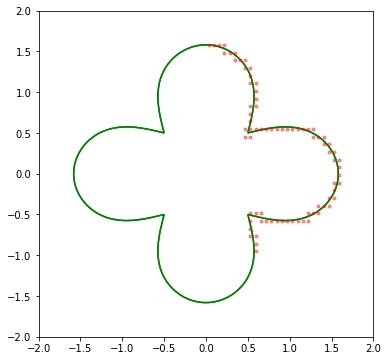

In [43]:
interval = array([[0,-1],[2,2]])
precision = 0.1
sss = Interval(interval).roots

k = 0.5
figure(figsize=(6,6))

contour(*mesh, h(*mesh,k)[0],levels=[0],colors=['g'])
contour(*mesh, f(*mesh),levels=[0],colors=['g'])

%time roots = list(sss(h,precision,k=k))
for root in roots :
    plot(*root,'r.',alpha=0.4)



In [26]:
args = []
for key,item in {'k':linspace(-2,2,50)}.items() :
    for i in item :
        args += [{key:i}]

%time rts = roots_parallel(h, interval, precision=0.1, args=args )

CPU times: user 547 ms, sys: 65.5 ms, total: 613 ms
Wall time: 2.66 s


(-2, 2)

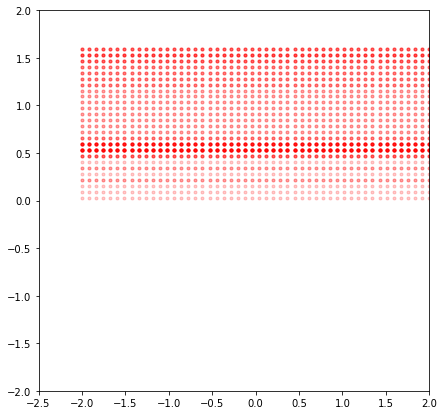

In [31]:
figure(figsize=(7,7))
for r,k in zip(rts,linspace(-2,2,50)) :
    for ri in r :
        plot(k,ri[0],'r.',alpha=0.2)
#         plot(k,ri[1],'b.')

xlim(-2.5,2)
ylim(-2,2)

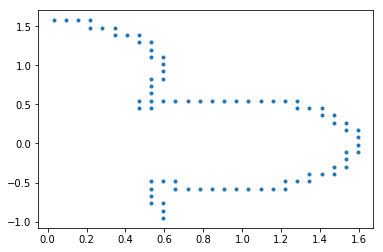

In [42]:
plot(rts[2,:,0],rts[2,:,1],'.')

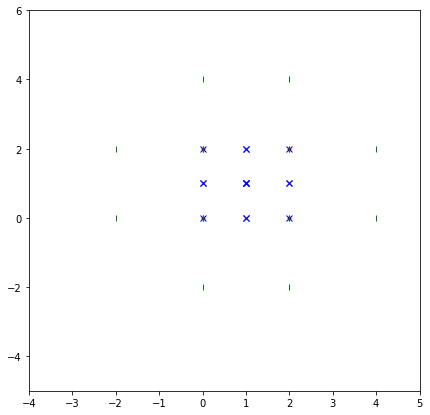

In [242]:
figure(figsize=(7,7))

bounds = array([[0,0],[2,2]])
precision = 0.1
# interval = Interval(bounds)
plot(*interval.mesh,'r.')

for nn in interval.refinements() :
    plot(*nn.mesh,'bx')
    
for nn in interval.neighbours() :
    plot(*nn.mesh,'g|')
    


xlim(-4,5)
ylim(-5,6);

In [319]:
interval.upper

array([2, 2])

In [105]:
interval.bounds

array([[2., 2.],
       [4., 5.]])

In [543]:
from scipy.ndimage import laplace

def init_inv_density(x) :
    return arcsin(1-2*x)
    
def init_density(x) :
    return 1-(sin(x)+1)/2
    
init = vectorize(init)
init_density = vectorize(init_density)

dt = 0.000001
dx = 0.01
invdx = 0.001

x = arange(-pi/2,3*pi/2,dx)
rho = init_density(x)

invx = arange(-1,2,invdx)
invrho = init_inv_density(invx)

# p = arange(-1,2,dp)
# G = init(p)

# bin_edges = linspace(-1,2,100)
# bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

# nanmask = ~isnan(G)*~isinf(G)
# G = G[nanmask]; p = p[nanmask]

/home/gszep/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.


/home/gszep/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/home/gszep/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in true_divide
  del sys.path[0]


(-1, 2)

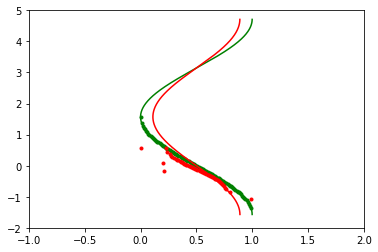

In [544]:
# gamma,_ = histogram(rho,bins=bin_edges,density=True)
plot(rho,x,'g-') 
plot(invx,invrho,'g.')


for i in range(25000) :
    
    rho += laplace(rho,mode='nearest')/dx**2 * dt
    
    nanmask = ~isnan(invrho)*~isinf(invrho)
    invrho = invrho[nanmask]; invx = invx[nanmask]

    invrho += laplace(invrho)/gradient(invrho)**2 * dt
#     G += laplace(-1./G,mode='constant',cval=0)/dp**2 * dt

# gamma,_ = histogram(rho,bins=bin_edges,density=True)
# plot(bin_centers,gamma,'r-') 
# plot(p,G,'r.')

plot(rho,x,'r-') 
plot(invx,invrho,'r.')

ylim(-2,5)
xlim(-1,2)

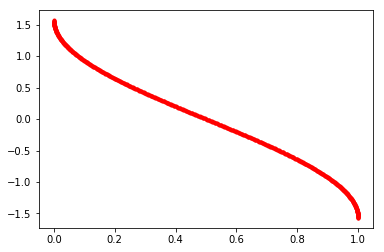

In [534]:
plot(invx,invrho,'r.')

In [429]:
laplace?

(-2, 2)

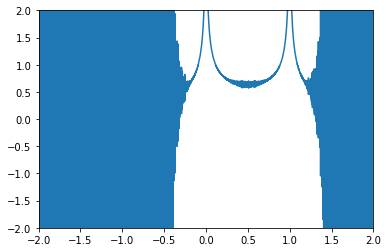

In [8]:
for i in range(1) :
    
    F = -1./G
    F[isinf(F)] = 0.0
    
    G += laplace(F,mode='nearest')/dx**2 * dt
    
    plot(x,G)
        

ylim(-2,2)
xlim(-2,2)

Text(0.5, 0, 'time')

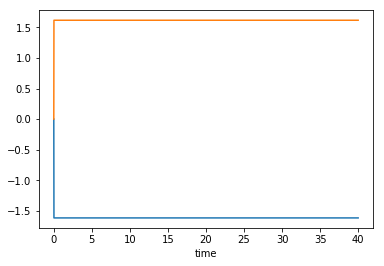

In [135]:
import PyDSTool
from matplotlib.pyplot import *

# we must give a name
DSargs = PyDSTool.args(name='normal-form')
# parameters
DSargs.pars = { 'cusp': 1,
                'width': 1,
                'r': 2000,
                'alpha': 1,
                'beta':3
              }

# rhs of the differential equation, including dummy variable w
DSargs.varspecs = {'L': 'r*((beta-cusp)*L-width*L**3+alpha)',
                   'T': 'r*((beta-cusp)*T-width*T**3-alpha)'}
DSargs.ics      = {'L': 0, 'T': 0 }

# initial conditions 
DSargs.tdomain = [0,40]                             # set the range of integration.
ode  = PyDSTool.Generator.Vode_ODEsystem(DSargs)    # an instance of the 'Generator' class.
traj = ode.compute('trajectory')                  # 
pd   = traj.sample()                                # Data for plotting
plot(pd['t'], pd['T'])
plot(pd['t'], pd['L'])
xlabel('time')                                      # Axes labels                                  # ...

In [145]:
# Prepare the system to start close to a steady state
ode.set(pars = {'beta': 1} )       # Lower bound of the control parameter 'i'
ode.set(ics =  {'L': 1.5, 'T': -1.5} )       # Close to one of the steady states present for i=-220

PyCont = PyDSTool.ContClass(ode)                 # Set up continuation class

PCargs = PyDSTool.args(name='EQ1', type='EP-C')  # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['alpha','beta']                      # control parameter(s) (it should be among those specified in DSargs.pars)
PCargs.MaxNumPoints = 450                        # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 2
PCargs.MinStepSize  = 1e-1
PCargs.StepSize     = 2e-1
PCargs.LocBifPoints = 'LP'                       # detect limit points / saddle-node bifurcations
PCargs.SaveEigen    = True                       # to tell unstable from stable branches

In [146]:
PyCont.newCurve(PCargs)
PyCont['EQ1'].forward()
clf()
PyCont.display(['alpha','beta'], stability=True)

PyDSTool_ExistError: 'Problem in _compute: Failed to compute tangent vector.'

CP Point found 


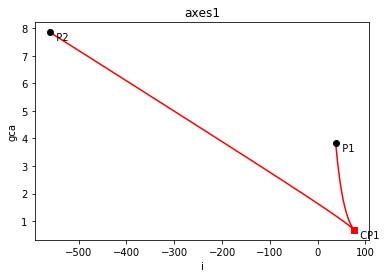

In [16]:
PCargs = PyDSTool.args(name='SN1', type='LP-C')
PCargs.initpoint    = 'EQ1:LP2'
PCargs.freepars     = ['i', 'gca']
PCargs.MaxStepSize  = 2
PCargs.LocBifPoints = ['CP']
PCargs.MaxNumPoints = 200
PyCont.newCurve(PCargs)
PyCont['SN1'].forward()
PyCont['SN1'].backward()
PyCont['SN1'].display(['i','gca'])
